# model

we want to test if the experiment was too difficult, i.e. if participant managed to do better than pure luck.

Let's assume the participants guessed randomly, this is our null hypothesis.

Let $(X_i)_{i\in \text{Exp}}$ be the numbers of true answer of the experiments i.

We have $X_i \sim \text{HyperGeom}(N=14, K=7,n=7)$ i.i.d.

We have : 
- $\mathbb{E}(X) = \mu = n \frac{K}{N}$.
- $\mathbb{V}(X) = \sigma = n \frac{K}{N} \frac{N-K}{N} \frac{N-n}{N-1}$

we notate the average number of true answers $\bar{X} = \frac{1}{n} \sum X_i$

By the central limit theorem,

$$ T = \sqrt{n} \frac{\bar{X} - \mu }{\sigma} \underset{n → ∞}{\sim} \mathcal{N}(0,1) $$

We have around 90 data points, but we will consider this approximation as valid.

Our hypothesis to test is that participants did better than pure luck. We will therefore reject $H_0$ if $T>s$ with $s$ a threshold defined such that the test has a nominal value $\alpha = 0.05$, that is $p(T>s) = \alpha \quad ⇔ \quad s = q_{1-\alpha}^{{N}(0,1)}$

-----------------------

We could do better by implementing an algorithm from this paper : https://www.sciencedirect.com/science/article/pii/S2215016121003009

# imports

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
expDf = pd.read_csv("clean-data/experiments.csv")
focusDf = pd.read_csv("clean-data/focusTimes.csv")
partiDf = pd.read_csv("clean-data/participants.csv")
slotsDf = pd.read_csv("clean-data/slots.csv")
scoreDf = pd.read_csv("computed-data/scores.csv")

In [ ]:
expDf = (expDf
  .set_index(["participantId","device","datasetId"])
  .join(
      scoreDf
      .set_index(["participantId","device","datasetId"])
  )
  .reset_index())

# Constants

1st, we write the constants

In [ ]:
N = 14
K = 7
n = 7

we compute the mean and variance

In [ ]:
mu = n*K /N
sigma = n * (K/N) * ((N-K)/N) * ((N-n)/(N-1))

In [ ]:
print(f"mu : {mu} sigma : {sigma}")

mu : 3.5 sigma : 0.9423076923076923


we chose a nominal value of 0.05

In [ ]:
alpha = 0.05

# plotting

In [ ]:
rv = stats.hypergeom(N, K, n)
x = np.arange(0, K+1)
pmf_true = rv.pmf(x)

In [ ]:
pd.DataFrame(
          expDf["nbTrue"]
          .value_counts()
          /expDf["nbTrue"]
          .shape[0])

,nbTrue
3,0.377778
4,0.266667
5,0.188889
2,0.100000
6,0.033333
1,0.033333


In [ ]:
randomTrueDf=(pd.DataFrame(
    pd.Series(pmf_true)
    .rename("Null distribution")
    )
  .join(
      pd.DataFrame(
          expDf["nbTrue"]
          .value_counts()
          /expDf["nbTrue"]
          .shape[0]).rename({"nbTrue":"Participants"}, axis=1)
      ))

In [ ]:
randomTrueDf=pd.melt(randomTrueDf, ignore_index=False ,value_vars=randomTrueDf.columns)

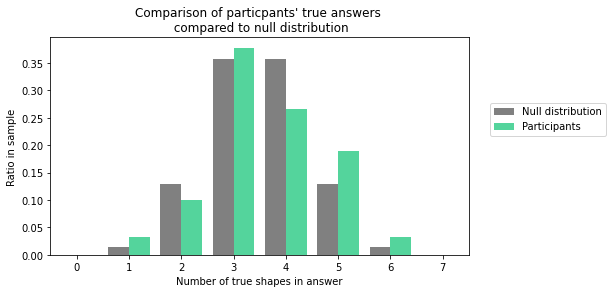

In [ ]:
plt.figure(figsize=(7.5,4))
ax = sns.barplot(data=randomTrueDf, x=randomTrueDf.index, y='value', hue='variable', palette=['grey','#3eea9f'])
plt.legend(bbox_to_anchor=(1.05,0.7), loc=2, borderaxespad=0.)
ax.set(title="Comparison of particpants' true answers \n compared to null distribution")
ax.set_xlabel("Number of true shapes in answer")
ax.set_ylabel("Ratio in sample")
plt.savefig("true-nb-compared-null.svg")

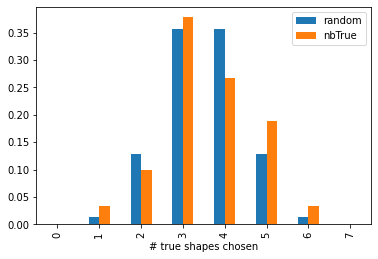

In [ ]:
(pd.DataFrame(
    pd.Series(pmf_true)
    .rename("random")
    )
  .join(
      pd.DataFrame(
          expDf["nbTrue"]
          .value_counts()
          /expDf["nbTrue"]
          .shape[0])
      )
  ).plot(kind="bar",xlabel="# true shapes chosen")

# Computing the test

we compute T

In [ ]:
(((expDf['trueProp'] * 7).mean()-mu)/sigma)*np.sqrt(n)

0.21837947329422067

we compute the threshold

In [ ]:
stats.norm.ppf(1-alpha)

1.6448536269514722

we can see the threshold is above our test statistic, therefore, we can't reject the hypothesis that participants did better than juste guessing randomly

# Are people helped by the fact that adjacent answer look similar

We need to find the distribution of max streak we should expect if people are choosing randomly.

We will compute the max streak for a lot of randomly generated data point to have the distribution expected under $H_0$

let's import the max streak function

In [ ]:
def compute_max_streak(dataFrame, condition = True, direction="forward") -> int:
  """Condition filters for True or False i the anwsers. Can accept three direction: forward, backward, both"""
  diffDf = [1]
  for i in range(1,len(dataFrame)):
      if dataFrame["isTrue"].values[i] == condition:
        diffDf.append(dataFrame["answerId"].values[i] - dataFrame["answerId"].values[i-1])
      else:
        diffDf.append(0)
  maxStreak = currentStreak = 0
  for d in diffDf:
      if direction == "both":
        d = np.abs(d)
      if direction == "backward":
        d += 2
      if d == 1:
        currentStreak += 1
        maxStreak = max(maxStreak, currentStreak)
      else:
        currentStreak = 0
  return maxStreak

In [ ]:
answers = pd.DataFrame([(index,typ) for index in range(1,8) for typ in (True,False)],columns=["answerId","isTrue"])

In [ ]:
compute_max_streak(answers.loc[np.random.choice(answers.shape[0],7,replace = False),:],False)

1

In [ ]:
answers = pd.DataFrame([(index,typ) for index in range(1,8) for typ in (True,False)],columns=["answerId","isTrue"])

randomMaxStreak = np.empty(10000,dtype=np.int8)

for i in range(len(randomMaxStreak)):
  randomMaxStreak[i] = compute_max_streak(answers.loc[np.random.choice(answers.shape[0],7,replace = False),:],False,"both")

In [ ]:

unique, counts = np.unique(randomMaxStreak, return_counts=True)
freqTheoretical = pd.DataFrame(counts,unique,columns = ["maxRandomStreak"])
freqTheoretical["maxRandomStreak"] = freqTheoretical["maxRandomStreak"] / freqTheoretical["maxRandomStreak"].sum()

In [ ]:
freqFalse = pd.DataFrame(
          expDf["maxFalseStreakBoth"].rename("False shapes")
          .value_counts()
          /expDf
          .shape[0])

freqTrue = pd.DataFrame(
          expDf["maxTrueStreakBoth"].rename("True shapes")
          .value_counts()
          /expDf
          .shape[0])

In [ ]:
freqTheoretical = freqTheoretical.rename(columns={'maxRandomStreak':'Null distribution'})

In [ ]:
maxStreak=(freqTheoretical
  .join(freqFalse)
  .join(freqTrue)
  )

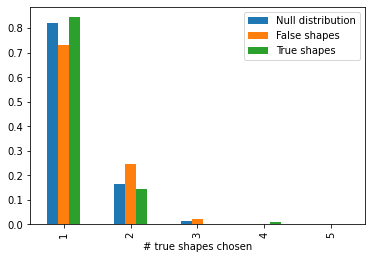

In [ ]:
(freqTheoretical
  .join(freqFalse)
  .join(freqTrue)
  ).plot(kind="bar",xlabel="# true shapes chosen")

In [ ]:
maxStreak=pd.melt(maxStreak, ignore_index=False ,value_vars=maxStreak.columns)

In [ ]:
maxStreak

,variable,value
1,Null distribution,0.820500
2,Null distribution,0.163000
3,Null distribution,0.015600
4,Null distribution,0.000800
5,Null distribution,0.000100
1,False shapes,0.733333
2,False shapes,0.244444
3,False shapes,0.022222
4,False shapes,NaN
5,False shapes,NaN


In [ ]:
sns.set_context('poster', 0.7)
sns.set_style('whitegrid')

In [ ]:
pal = sns.color_palette("tab10")
print(pal.as_hex())

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


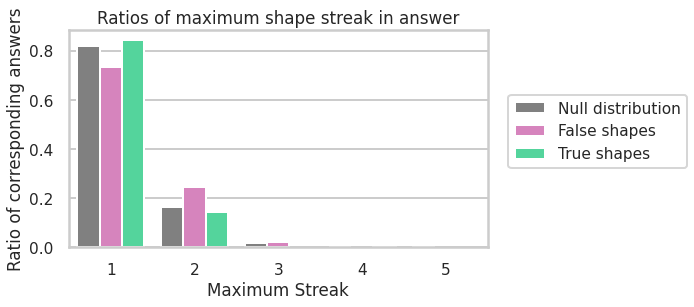

In [ ]:
plt.figure(figsize=(7.5,4))
ax = sns.barplot(data=maxStreak, x=maxStreak.index, y='value', hue='variable', palette=['grey','#e377c2','#3eea9f'])
plt.legend(bbox_to_anchor=(1.05,0.7), loc=2, borderaxespad=0.)
ax.set(title="Ratios of maximum shape streak in answer")
ax.set_xlabel("Maximum Streak")
ax.set_ylabel("Ratio of corresponding answers")
plt.savefig('max-streak-proportion.svg')

In [ ]:
maxStreak

,variable,value
1,Null distribution,0.820500
2,Null distribution,0.163000
3,Null distribution,0.015600
4,Null distribution,0.000800
5,Null distribution,0.000100
1,False shapes,0.733333
2,False shapes,0.244444
3,False shapes,0.022222
4,False shapes,NaN
5,False shapes,NaN


Let's notate $X_i$ the maxStreak of experiment $i$.

- All the $X_i$ from all groups are independent of each other
- The the $X_i$ are ordinal,


- Under the null hypothesis $H_0$, the distributions of both the max streak generated randomly and the max streak measured during the experiments are equal.
- The alternative hypothesis $H_1$ is that the distributions are not equal.

We can therefore use the Mann–Whitney U test, and we choose beforehand a nominal value $\alpha = 0.05$

In [ ]:
expDf

,participantId,device,datasetId,pauseTime,sortingTime,time,experimentOrder,nbTrue,trueProp,maxTrueStreak,maxTrueStreakBoth,maxFalseStreakBoth,veracityScore,levenDist
0,16,VR,1,184.909470,269.096130,2022-04-27 13:36:32,3,6,0.857143,1,1,1,0.653061,5
1,16,VR,2,342.400177,221.314514,2022-04-27 13:49:19,4,4,0.571429,1,1,1,0.244898,7
2,13,VR,2,34.628632,304.130951,2022-04-27 14:43:34,1,3,0.428571,1,1,1,0.387755,5
3,13,VR,1,162.141891,227.080627,2022-04-27 14:54:16,2,5,0.714286,1,1,1,0.530612,5
4,13,Comp,1,370.547791,247.132828,2022-04-27 15:13:53,3,3,0.428571,1,1,3,0.224490,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,15,Comp,2,9.416518,210.855438,2022-05-02 18:29:12,3,4,0.571429,1,1,1,0.326531,7
86,15,Comp,1,6.016559,131.948090,2022-05-02 18:34:39,4,4,0.571429,1,1,1,0.346939,7
87,16,Comp,1,6.350022,250.443741,2022-04-27 13:11:44,1,5,0.714286,1,2,1,0.591837,6
88,16,Comp,2,122.701782,260.243805,2022-04-27 13:22:12,2,2,0.285714,1,1,1,0.204082,7


In [ ]:
serie1 = randomMaxStreak
serie2 = expDf["maxFalseStreakBoth"]

U1, p = stats.mannwhitneyu(serie1, serie2,alternative="less")

print(f"RandomMaxStreak : {serie1.mean()}, MeasuredMaxStreak : {serie2.mean()}, p-value : {p}")

RandomMaxStreak : 1.197, MeasuredMaxStreak : 1.288888888888889, p-value : 0.01669843339280403


In [ ]:
serie1 = randomMaxStreak
serie2 = expDf["maxTrueStreakBoth"]

U1, p = stats.mannwhitneyu(serie1, serie2)

print(f"RandomMaxStreak : {serie1.mean()}, MeasuredMaxStreak : {serie2.mean()}, p-value : {p}")

RandomMaxStreak : 1.197, MeasuredMaxStreak : 1.1777777777777778, p-value : 0.2748025806886984


it seems that the measured max streaks are bigger than the random one, suggesting that participants were able to sort even the false shapes, probably using the fact that chronologically adjacent shapes are generally similar. However, this result is not significant, so we need further experiments to confirm this.